<a href="https://colab.research.google.com/github/BogdanT54/Serii-de-Timp/blob/Proiect/Analiza_S%26P500_(Proiect_Serii_Timp).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Caiet lucru analiza S&P 500 (2015-2025)**

Cerinte:

o   Prezentarea problemei

o   Surse de date (se extrag două serii de timp, posibil interdependente)

o   Modele econometrice folosite

    - estimarea unui model univariat de timp pentru fiecare serie de timp

    - estimarea unui model multivariat pentru interdependența dintre ele

o   Concluzii și interpretări

  În realizarea proiectului se va avea în vederea ilustrarea următoarelor concepte de analiză a seriilor de timp:

1.      Modele cu trend determinist sau stochastic

2.      Serii staționare

3.      Modele ARMA-ARIMA-SARIMA

4.      Predicția punctuală și predicția pe interval de încredere

5.      Modele de cointegrare și modele VAR.


In [ ]:
# Instalează pachetele necesare (rulat o singură dată)
!pip3 install yfinance statsmodels arch seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 13.1 MB/s eta 0:00:00


In [ ]:
# Importuri
import yfinance as yf
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import statsmodels.tsa.stattools as ts
from google.colab import files
from arch.unitroot import ADF, PhillipsPerron, KPSS
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [ ]:
#Fac un dataframe cu fisierul dat
sp500 = pd.read_csv('sp500.csv', index_col=0, parse_dates=True)

#Verific Df-ul
sp500.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [ ]:
#Prelucram randamentele logaritmice si curatam valorile lipsa
sp500_log_returns = np.log(sp500 / sp500.shift(1)).replace([np.inf, -np.inf], np.nan).dropna()

#Afisez
sp500_log_returns.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-24,-0.000711,-0.005347,-0.002391,0.001221,0.079516,0.001221
2015-11-25,-0.000535,0.007703,0.002339,-0.000129,-0.308755,-0.000129
2015-11-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-11-27,0.000139,-0.001041,-0.000230,0.000593,-0.665240,0.000593
2015-11-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


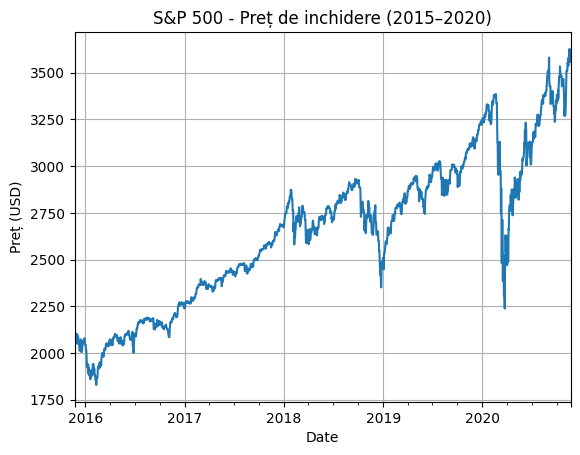

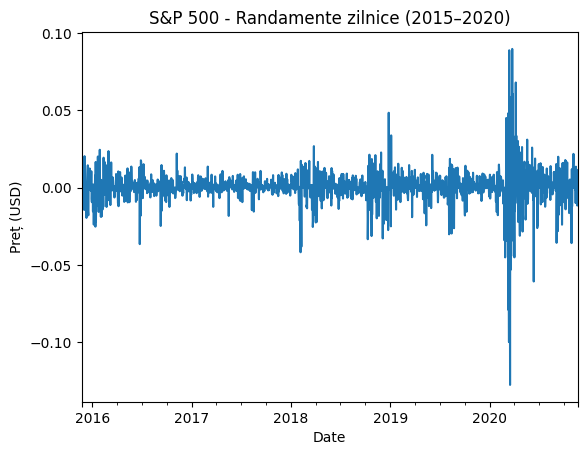

In [ ]:
# Plot - Preț ajustat real
sp500['Close'].plot(title='S&P 500 - Preț de inchidere (2015–2020)')
plt.ylabel("Preț (USD)")
plt.grid(True)
plt.show()

# Plot - Preț ajustat randamente logartimice
sp500_log_returns['Close'].plot(title='S&P 500 - Randamente zilnice (2015–2020)')
plt.ylabel("Preț (USD)")
plt.show()

# **📈 Evoluția S&P 500 (2015–2020)**

**🔹 Observații tehnice:**

Trend general ascendent între 2016 și începutul lui 2020.

Corecții semnificative la finalul lui 2018 și în martie 2020.

Volatilitate crescută în perioadele de incertitudine economică.

**🔹 Evenimente economice relevante:**

2015–2016: Îngrijorări legate de economia Chinei și scăderea prețului petrolului.

2018: Tensiuni comerciale între SUA și China; majorarea ratelor dobânzilor de către FED.

2020: Pandemia COVID-19 a provocat o scădere rapidă de aproximativ 34% în martie, urmată de o revenire susținută de stimulente fiscale și monetare.

***⏩⏩⏩Deoarece trendul este stochastic (Seria urcă sau coboară la întâmplare, cu "salturi" de la o perioadă la alta) am aplicat diferentierea prin logaritmarea randametelor pentru a obtine un trend deterministic.***

# **📊 Randamente zilnice S&P 500**

**🔹 Observații tehnice:**

Randamente relativ stabile în perioadele de creștere economică.

Spike-uri semnificative în perioadele de criză, indicând volatilitate ridicată.

Distribuție leptokurtică: frecvență crescută a valorilor extreme.

**🔹 Interpretare:**

Randamentele zilnice sunt în general staționare, dar prezintă heteroscedasticitate în perioadele de stres economic.

Modelarea volatilității poate fi eficient realizată prin modele ARCH/GARCH.

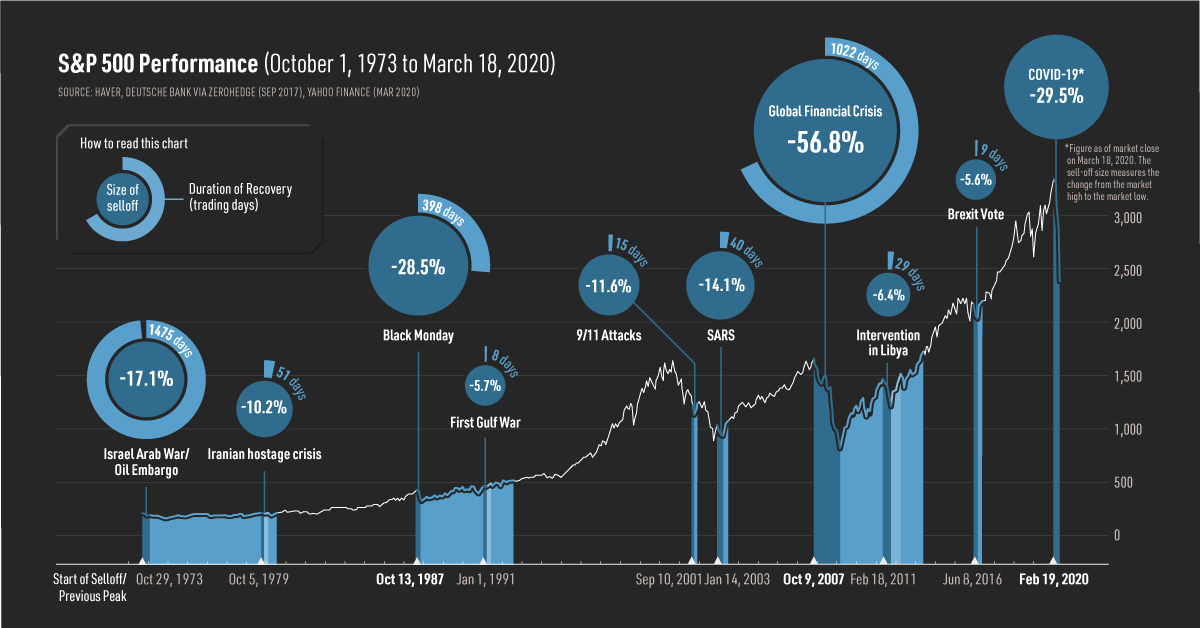

In [ ]:
def analiza_trend(series, title=''):
    print(f'=== Analiza trend pentru {title} ===\n')

    # 2. Test ADF
    adf = ADF(series, trend='ct')
    print(adf.summary(),'\n')
    adf_stationary = adf.pvalue < 0.05

    # 3. Test KPSS
    kpss_test = KPSS(series, trend='ct')
    print(kpss_test.summary(),'\n')
    kpss_stationary = kpss_test.pvalue > 0.05

    # 4. Test Phillips-Perron
    pp = PhillipsPerron(series, trend='ct')
    print(pp.summary(),'\n')
    pp_stationary = pp.pvalue < 0.05

    # 5. Concluzie automată
    print('--- Concluzie ---')
    if adf_stationary and pp_stationary and kpss_stationary:
        print(f'Seria {title} are un trend determinist.')
    elif not adf_stationary and not pp_stationary and not kpss_stationary:
        print(f'Seria {title} are un trend stochastic.')
    else:
        print(f'Seria {title} necesită o analiză mai detaliată (rezultate mixte între teste).')
    print('=============================\n')

analiza_trend(sp500['Close'], title='S&P 500 - Close')
analiza_trend(sp500_log_returns['Close'], title='S&P 500 - Close')

=== Analiza trend pentru S&P 500 - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.173
P-value                         0.005
Lags                               23
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  0.209
P-value                         0.012
Lags                               27
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.149
P-value                         0.005
Lags                               25
-------------------

<Figure size 1000x500 with 0 Axes>

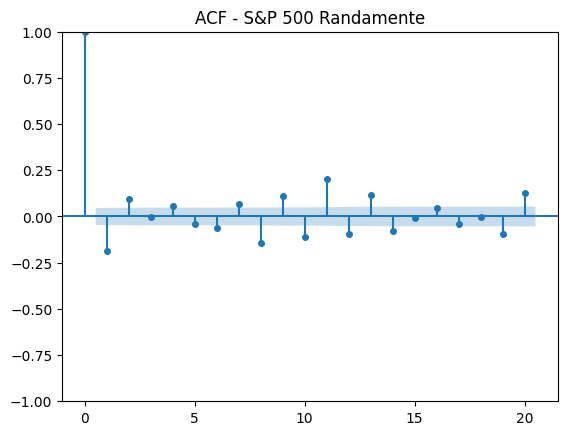

<Figure size 1000x500 with 0 Axes>

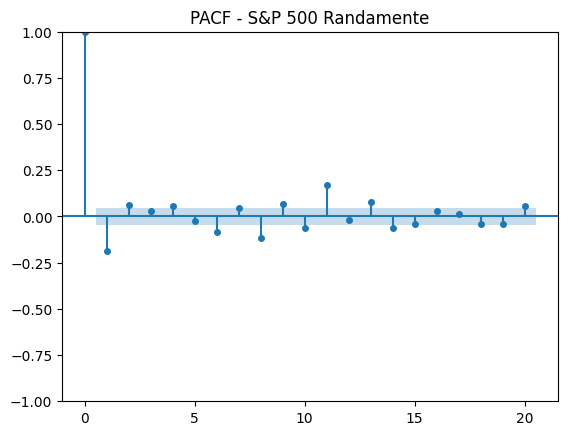

In [ ]:
# ACF (pentru q – partea MA)
plt.figure(figsize=(10, 5))
plot_acf(sp500_log_returns['Close'], lags=20, markersize=4)
plt.title('ACF - S&P 500 Randamente')
plt.show()

# PACF (pentru p – partea AR)
plt.figure(figsize=(10, 5))
plot_pacf(sp500_log_returns['Close'], lags=20, markersize=4)
plt.title('PACF - S&P 500 Randamente')
plt.show()

# **Rezultate ACF si PACF**

Din PACF si ACF ne se sugereaza sa folosim un AR(2) din PACF si un MA(2) sau MA(3) din ACF.

Mai jos, vom testa mai multe variante de ARIMA pentru a determina care este cel mai bun pentru analiza noastra.

In [ ]:
#Testare multiple modele ARIMA pentru S&P500 pentru a determina care este cel mai bun

def testeaza_modele_arima(serie, p_max=3, d=0, q_max=3):
    rezultate = []

    for p in range(p_max + 1):
        for q in range(q_max + 1):
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")

                    model = ARIMA(serie, order=(p, d, q))
                    fitted = model.fit()
                    resid = fitted.resid.dropna()

                    rezultate.append({
                        'Model': f'ARIMA({p},{d},{q})',
                        'AIC': fitted.aic,
                        'BIC': fitted.bic,
                        'HQIC': fitted.hqic,
                        'LogLik': fitted.llf,
                        'Num_Params': len(fitted.params),
                        'Sigma2': np.var(resid, ddof=1),
                        'Skewness': skew(resid),
                        'Kurtosis': kurtosis(resid),
                    })

            except Exception as e:
                continue

    df_rezultate = pd.DataFrame(rezultate)
    df_rezultate = df_rezultate.sort_values(by='AIC')
    return df_rezultate

#Rulam functia pentru randamentele logaritmate si p,q max=3
df_arima = testeaza_modele_arima(sp500_log_returns['Close'], p_max=3, d=0, q_max=3)
df_arima.head(20)

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Sigma2,Skewness,Kurtosis
2,"ARIMA(0,0,2)",-11625.205198,-11603.170050,-11617.076607,5816.602599,4,0.000100,-1.896389,34.848769
3,"ARIMA(0,0,3)",-11624.212126,-11596.668191,-11614.051387,5817.106063,5,0.000099,-1.874059,34.720678
9,"ARIMA(2,0,1)",-11624.096461,-11596.552525,-11613.935721,5817.048230,5,0.000099,-1.805362,34.118160
8,"ARIMA(2,0,0)",-11623.690831,-11601.655682,-11615.562239,5815.845416,4,0.000100,-1.858358,34.179849
6,"ARIMA(1,0,2)",-11623.264066,-11595.720130,-11613.103326,5816.632033,5,0.000100,-1.896055,34.851994
12,"ARIMA(3,0,0)",-11623.051701,-11595.507765,-11612.890961,5816.525850,5,0.000100,-1.880596,34.691236
5,"ARIMA(1,0,1)",-11622.524397,-11600.489249,-11614.395806,5815.262199,4,0.000100,-1.840046,33.707207
13,"ARIMA(3,0,1)",-11621.493167,-11588.440444,-11609.300279,5816.746583,6,0.000099,-1.870801,34.612112
7,"ARIMA(1,0,3)",-11620.785691,-11587.732968,-11608.592803,5816.392845,6,0.000100,-1.909759,34.958310
11,"ARIMA(2,0,3)",-11620.560816,-11581.999306,-11606.335781,5817.280408,7,0.000099,-1.878886,34.556284


# **✅ Alegem ARIMA(2,0,1)**

Modelul ARIMA(2,0,1) e ca un echilibru bun între a învăța din trecut și a reacționa la surprize. Folosește ultimele două mișcări ale pieței și ajustează pe baza erorilor recente.

Dintre toate modelele testate, acesta are cele mai bune scoruri de performanță și nu e prea complicat – doar 5 parametri. E destul de precis pentru prognoze scurte și destul de simplu cât să nu ne încurcăm în detalii inutile.

In [ ]:
#ARIMA (2,0,1) - Salvez cel mai bun model
best_model_sp500_arima = ARIMA(sp500_log_returns['Close'], order=( 2, 0, 1))
best_fitted_sp500 = best_model_sp500_arima.fit()
print(best_fitted_sp500.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1824
Model:                 ARIMA(2, 0, 1)   Log Likelihood                5817.048
Date:                Sat, 03 May 2025   AIC                         -11624.096
Time:                        14:57:01   BIC                         -11596.553
Sample:                    11-24-2015   HQIC                        -11613.936
                         - 11-20-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.089      0.276      -0.000       0.001
ar.L1          0.2792      0.130      2.152      0.031       0.025       0.534
ar.L2          0.1438      0.026      5.561      0.0

# **Interpretare**

AIC = -11624.096, BIC = -11596.553 → valori foarte bune, confirmă alegerea modelului pe baza criteriilor informaționale.

Ljung-Box (lag 1) p-val = 0.97 → reziduurile sunt „white noise”; nu rămâne autocorelare nerezolvată → modelul este bine specificat pentru medie.

# **⚠️ Probleme structurale în reziduuri**

❗ Distribuție nenormală:
Jarque-Bera p-val = 0.00 → respingem ipoteza normalității.

Skew = -1.81, Kurtosis = 37.12 → reziduurile sunt asimetrice și leptokurtice (prezență de valori extreme), ceea ce contrazice ipoteza normalității și confirmă natura financiară a seriei.

❗ Heteroscedasticitate prezentă:

Valori mari ale kurtosis și statistică indicatoare JB, combinate cu sigma² mică dar instabilă, sugerează volatilitate condiționată → nu putem presupune varianță constantă.


# **📈 Implicație: necesar un model GARCH**

Modelul ARIMA(2,0,1) explică foarte bine componenta de medie condiționată, însă:

Nu capturează dinamica volatilității, care este esențială în modelarea riscului financiar.

Este justificată aplicarea unui model GARCH (ex: GARCH(1,1)) asupra reziduurilor pentru a modela heteroscedasticitatea condiționată, fenomen tipic în serii de log-randamente.

# **✅ Concluzie statistică**

Modelul ARIMA(2,0,1) este:

corect specificat pentru componenta de medie;

semnificativ statistic în toți coeficienții dinamici;

însă incomplet fără o extensie GARCH pentru a aborda varianța condiționată.



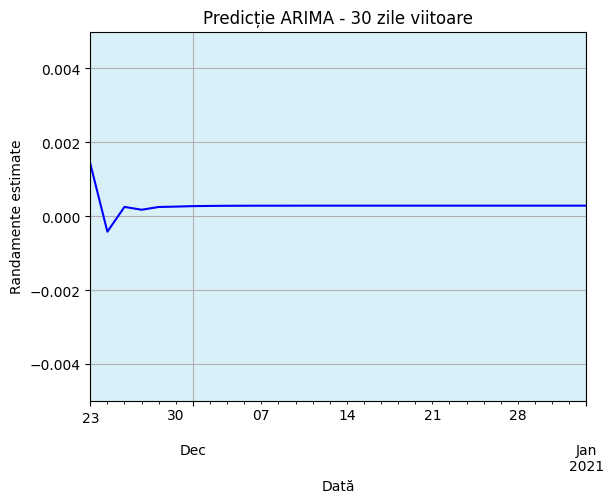

In [ ]:
forecast = best_fitted_sp500.get_forecast(steps=30)
forecast_df = forecast.summary_frame()

# Setăm index cu date reale
last_date = sp500_log_returns['Close'].index[-1]
forecast_df.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

# Plot mai clar
forecast_df['mean'].plot(title='Predicție ARIMA - 30 zile viitoare', color='blue')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='skyblue', alpha=0.3)
plt.ylabel('Randamente estimate')
plt.xlabel('Dată')
plt.grid(True)
plt.ylim(-0.005, 0.005)  # zoom pe variație mică (~±0.5%)
plt.show()

=== SARIMA pe Randamente Trimestriale ===
                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                   21
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 4)   Log Likelihood                 116.921
Date:                           Sat, 03 May 2025   AIC                           -223.843
Time:                                   14:57:09   BIC                           -218.620
Sample:                               12-31-2015   HQIC                          -222.710
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4018      0.519     -0.774      0.439      -1.419       0.616
m

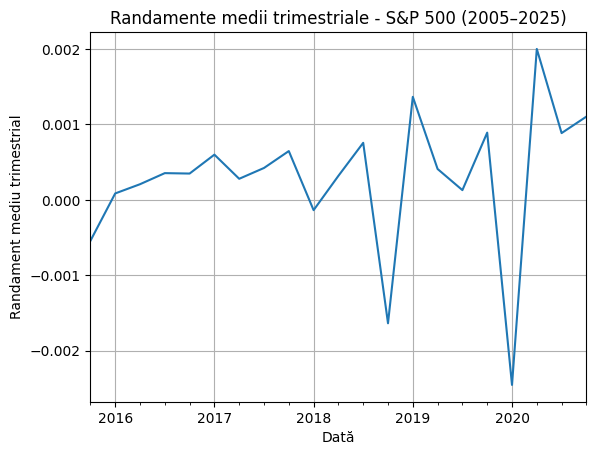

In [ ]:
# Randamente medii trimestriale
sp500_quarterly_returns = sp500_log_returns['Close'].resample('Q').mean().dropna()

# SARIMA(p,d,q)(P,D,Q,s) → alegem p=1, d=0, q=1 și sezonalitate s=4 (trimestrială)
model_q = SARIMAX(sp500_quarterly_returns, order=(1, 0, 1), seasonal_order=(1, 0, 1, 4))
results_q = model_q.fit(disp=False)

# Rezumat
print("=== SARIMA pe Randamente Trimestriale ===")
print(results_q.summary())

# Plot evoluție în timp
sp500_quarterly_returns.plot(title='Randamente medii trimestriale - S&P 500 (2005–2025)', linewidth=1.5)
plt.ylabel('Randament mediu trimestrial')
plt.xlabel('Dată')
plt.grid(True)
plt.show()

In [ ]:
#Reziduurile modelului ARIMA(2,0,1)
r_sp500 = best_fitted_sp500.resid
r_sp500.head()

#Reziduurile patrate
rsq_sp500 = r_sp500**2
rsq_sp500.head()

,0
Date,
2015-11-24,8.700844e-07
2015-11-25,6.036907e-08
2015-11-26,1.740368e-07
2015-11-27,6.562588e-08
2015-11-28,4.653988e-08


# **🔍 Scopul calculului reziduurilor și al pătratelor acestora**

-Extragem reziduurile modelului ARIMA(2,0,1) pentru a izola partea neexplicată a seriei.

-Calculăm pătratul reziduurilor pentru a evidenția comportamentul varianței în timp.

-Pătratele reziduurilor sunt folosite pentru a analiza prezența autocorelației în varianță.

-Dacă există autocorelare în reziduurile pătrate, înseamnă că avem efecte ARCH – adică varianța depinde de valorile trecute.

-Acest lucru indică că modelul ARIMA nu a captat corect dinamica volatilității.

-Justifică aplicarea unui model GARCH, care modelează explicit varianța condițională a erorii.

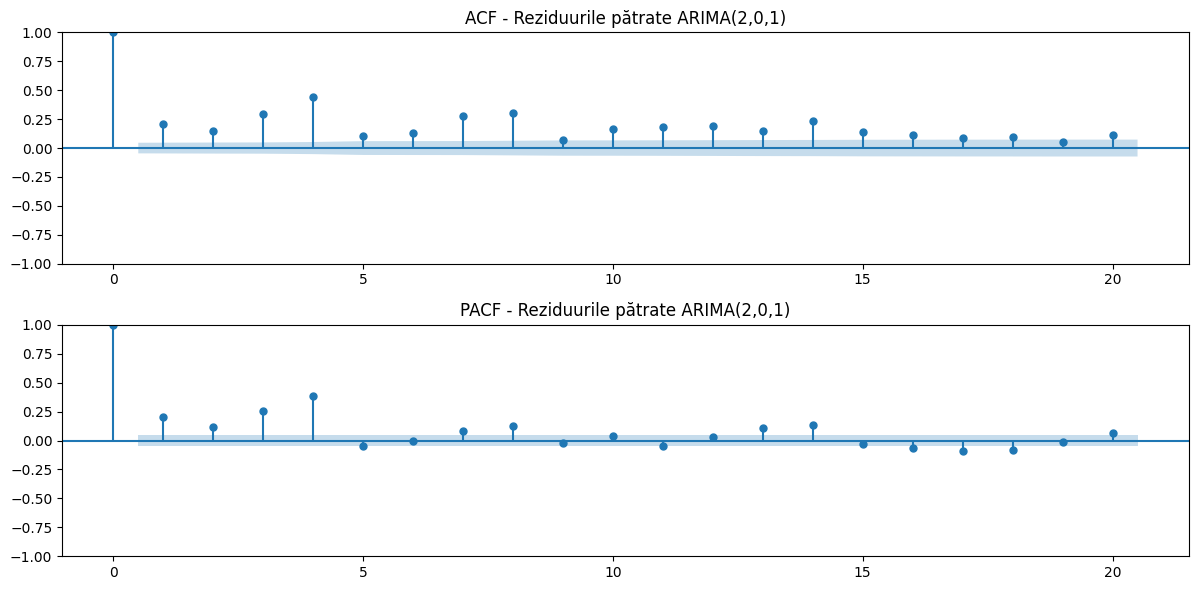

In [ ]:
# ACF și PACF pe reziduurile pătrate
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(rsq_sp500.dropna(), ax=ax[0], lags=20, title='ACF - Reziduurile pătrate ARIMA(2,0,1)')
plot_pacf(rsq_sp500.dropna(), ax=ax[1], lags=20, title='PACF - Reziduurile pătrate ARIMA(2,0,1)')
plt.tight_layout()
plt.show()

In [ ]:
# Apelăm testul pe reziduurile modelului ARIMA
arch_test = het_arch(r_sp500.dropna(), nlags=10)

# Despachetăm rezultatul
lm_stat, lm_pvalue, f_stat, f_pvalue = arch_test

# Afișăm tot output-ul organizat
print("=== Test ARCH-LM (Engle) pe reziduurile ARIMA(2,0,1) ===")
print(f"LM Statistic     : {lm_stat:.4f}")
print(f"LM p-value       : {lm_pvalue:.4f}")
print(f"F Statistic      : {f_stat:.4f}")
print(f"F p-value        : {f_pvalue:.4f}")
print("========================================================")

=== Test ARCH-LM (Engle) pe reziduurile ARIMA(2,0,1) ===
LM Statistic     : 481.3151
LM p-value       : 0.0000
F Statistic      : 65.1175
F p-value        : 0.0000


| Valoare                    | Explicație                                                                                                                                                                                                        |
| -------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **LM Statistic: 481.3151** | Aceasta este statistica testului Lagrange Multiplier (LM), calculată pentru a verifica existența **efectelor ARCH** (adică autocorelare în pătratul reziduurilor). O valoare mare indică prezența acestor efecte. |
| **LM p-value: 0.0000**     | Probabilitatea de a obține o valoare LM atât de mare dacă ipoteza nulă (varianță constantă) este adevărată. Valoarea 0.0000 indică o probabilitate aproape zero ⇒ respingem ipoteza nulă.                         |
| **F Statistic: 65.1175**   | O statistică alternativă, care evaluează același lucru ca LM, dar pe baza unei regresii auxiliare (F-test pentru semnificația regresiei asupra pătratelor reziduurilor).                                          |
| **F p-value: 0.0000**      | Valoare-p asociată cu F Statistic. Din nou, foarte mică ⇒ confirmă rezultatul LM: **varianța nu este constantă în timp**.                                                                                         |

# **✅ Concluzie**

Reziduurile modelului ARIMA(2,0,1) prezintă heteroscedasticitate de tip ARCH, adică varianța erorii este condițională și variază în timp.

⇒ Modelul ARIMA captează bine media, dar nu și volatilitatea.

⇒ Este justificată estimarea unui model GARCH(p,q) pe reziduuri sau direct pe serie.

In [ ]:
results = []

# Testăm p și q între 1 și 2 (poți extinde)
for p in range(1, 5):
    for q in range(1, 5):
        model = arch_model(r_sp500.dropna(), mean='Zero', vol='GARCH', p=p, q=q)
        fitted = model.fit(disp='off')
        results.append({
            'Model': f'GARCH({p},{q})',
            'AIC': fitted.aic,
            'BIC': fitted.bic,
            'LogLik': fitted.loglikelihood
        })

# Sortare după AIC
df_results = pd.DataFrame(results).sort_values(by='AIC')
print(df_results)

         Model           AIC           BIC       LogLik
1   GARCH(1,2) -12996.017874 -12973.982726  6502.008937
2   GARCH(1,3) -12981.687171 -12954.143235  6495.843585
9   GARCH(3,2) -12978.938349 -12945.885626  6495.469174
8   GARCH(3,1) -12969.272606 -12941.728670  6489.636303
5   GARCH(2,2) -12969.261070 -12941.717134  6489.630535
10  GARCH(3,3) -12968.574805 -12930.013295  6491.287403
4   GARCH(2,1) -12967.468007 -12945.432858  6487.734003
13  GARCH(4,2) -12966.671774 -12928.110264  6490.335887
12  GARCH(4,1) -12965.771112 -12932.718389  6488.885556
0   GARCH(1,1) -12962.418077 -12945.891716  6484.209039
3   GARCH(1,4) -12962.081634 -12929.028911  6487.040817
11  GARCH(3,4) -12956.548296 -12912.477999  6486.274148
14  GARCH(4,3) -12954.141392 -12910.071095  6485.070696
6   GARCH(2,3) -12951.852791 -12918.800068  6481.926396
15  GARCH(4,4) -12940.491681 -12890.912597  6479.245841
7   GARCH(2,4) -12932.972054 -12894.410544  6473.486027


In [ ]:
#Luam cel mai bun model
best_model_garch = arch_model(r_sp500.dropna(), mean='Zero', vol='GARCH', p=1, q=2)
best_result = best_model_garch.fit()
print(best_result.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: -6502.008941116742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6502.008937192111
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                6502.01
Distribution:                  Normal   AIC:                          -12996.0
Method:            Maximum Likelihood   BIC:                          -12974.0
                                        No. Observations:                 1824
Date:                Sat, May 03 2025   Df Residuals:                     1824
Time:                        14:57:23   Df Model:                            0
         

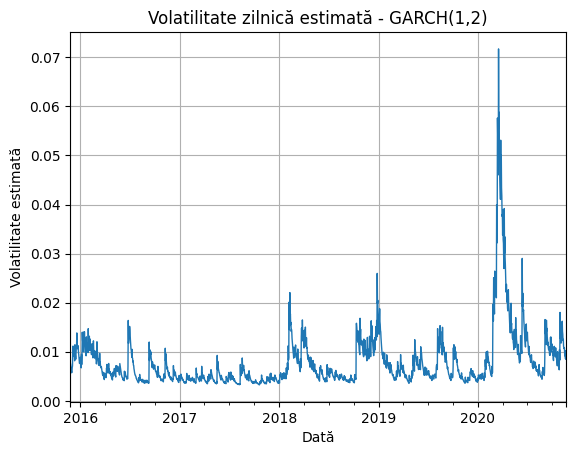

In [ ]:
# Plot volatilitate condițională (volatilitatea estimată în fiecare zi)
best_result.conditional_volatility.plot(title='Volatilitate zilnică estimată - GARCH(1,2)', linewidth=1)
plt.ylabel('Volatilitate estimată')
plt.xlabel('Dată')
plt.grid(True)
plt.show()

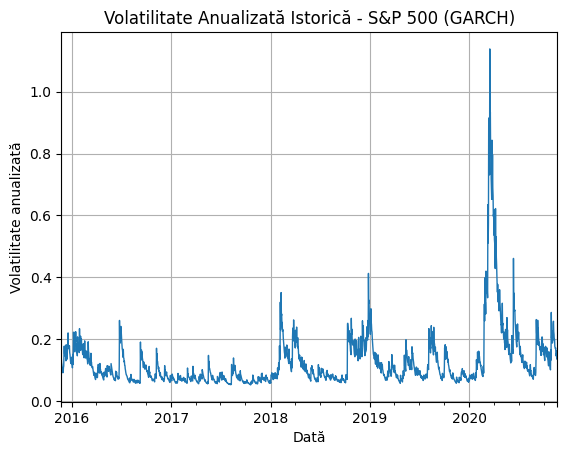

In [ ]:
# Volatilitate anualizată istorică
vol_anualizata_istoric = best_result.conditional_volatility * np.sqrt(252)

# Plot istoric
vol_anualizata_istoric.plot(title='Volatilitate Anualizată Istorică - S&P 500 (GARCH)', linewidth=1)
plt.ylabel('Volatilitate anualizată')
plt.xlabel('Dată')
plt.grid(True)
plt.show()

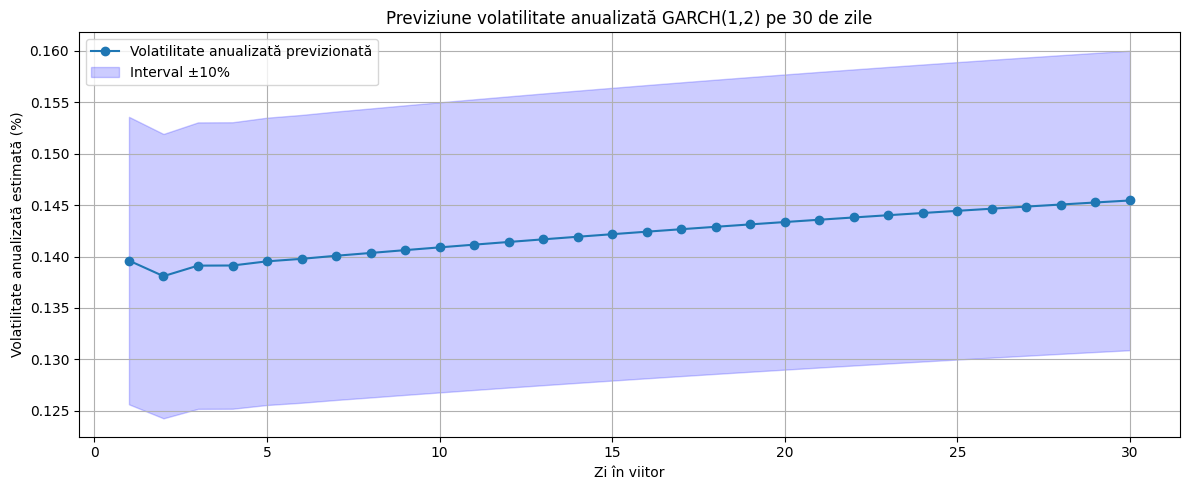

In [ ]:
# Realizăm forecast-ul de volatilitate pe următoarele 30 de zile folosind modelul GARCH(1,2) estimat anterior
forecast_obj = best_result.forecast(horizon=30)

# Extragem valorile prognozate pentru varianță din ultima observație cunoscută
forecast_var = forecast_obj.variance.values[-1]

# Calculăm volatilitatea (rădăcina pătrată a varianței) pe fiecare zi viitoare
forecast_vol = np.sqrt(forecast_var)

# Construim un interval de încredere aproximativ de ±10%
ci_margin = 0.10 * forecast_vol
lower = forecast_vol - ci_margin
upper = forecast_vol + ci_margin

# Anualizăm valorile estimate ale volatilității pentru a fi comparabile (252 zile de tranzacționare pe an)
forecast_vol_ann = forecast_vol * np.sqrt(252)
lower_ann = lower * np.sqrt(252)
upper_ann = upper * np.sqrt(252)

# Vizualizarea grafică a traiectoriei estimate a volatilității
plt.figure(figsize=(12, 5))
plt.plot(range(1, 31), forecast_vol_ann, label='Volatilitate anualizată previzionată', marker='o')

# Adăugăm banda de incertitudine ±10% în jurul valorii estimate
plt.fill_between(range(1, 31), lower_ann, upper_ann, color='blue', alpha=0.2, label='Interval ±10%')

# Etichete și layout grafic
plt.title('Previziune volatilitate anualizată GARCH(1,2) pe 30 de zile')
plt.xlabel('Zi în viitor')
plt.ylabel('Volatilitate anualizată estimată (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Linia albastră punctată reprezintă media estimată a volatilității condiționate anualizate pentru fiecare din următoarele 30 de zile. Observăm:

La început, volatilitatea se stabilizează ușor sub 14% anualizat.

Pe măsură ce orizontul temporal crește, estimarea tinde ascendent către o valoare de echilibru în jur de 14,5%.

Aceasta reflectă comportamentul tipic al unui model GARCH, în care previziunile de volatilitate se întorc treptat spre media de lungă durată, în absența unor șocuri viitoare.

In [ ]:
#Descarc datele OHLC pentru ticker-ul META (Perioada similara cu cea a S&P500 din csv)
meta = yf.download('META', start='2015-11-23', end='2020-11-20', interval='1d')
meta.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2015-11-23,106.448303,106.965868,105.582389,106.687183,19897200
2015-11-24,105.243980,105.990462,103.900315,105.502763,23577300
2015-11-25,104.915527,106.099940,104.606976,105.831210,15150800
2015-11-27,104.955338,105.462947,104.368109,105.283791,5913100
2015-11-30,103.751022,105.602298,103.263323,105.343515,20383200


In [ ]:
#Prelucram randamentele logaritmice si curatam valorile lipsa
meta_log_returns = np.log(meta / meta.shift(1)).replace([np.inf, -np.inf], np.nan).dropna()
meta_log_returns.head()

Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2015-11-24,-0.011378,-0.009161,-0.016060,-0.011164,0.169705
2015-11-25,-0.003126,0.001032,0.006778,0.003108,-0.442231
2015-11-27,0.000379,-0.006022,-0.002286,-0.005186,-0.940883
2015-11-30,-0.011541,0.001320,-0.010642,0.000567,1.237541
2015-12-01,0.027254,0.009848,0.007203,-0.009589,0.111255


In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Combinăm seriile într-un DataFrame
data = pd.concat([sp500['Close'], meta['Close']], axis=1)
data.columns = ['sp500', 'meta']
data.dropna(inplace=True)

# Testul Johansen
johansen_test = coint_johansen(data, det_order=0, k_ar_diff=1)

# Statistici de test și valori critice
print('Statistici de test:', johansen_test.lr1)
print('Valori critice (95%):', johansen_test.cvt[:, 1])

Statistici de test: [16.16215509  0.21279446]
Valori critice (95%): [15.4943  3.8415]


In [ ]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order

# Selectarea întârzierii optime (pe datele în nivel, cointegrate)
lag_selection = select_order(data, maxlags=10, deterministic="co")
opt_lag = lag_selection.aic  # Poți înlocui cu .bic sau .hqic dacă preferi alt criteriu

# Estimarea modelului VECM
vecm_model = VECM(data, k_ar_diff=opt_lag, coint_rank=1, deterministic="co")  # "co" = constant doar în relația de cointegrare
vecm_result = vecm_model.fit()

# Rezumatul estimării
print(vecm_result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation sp500
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.0796      6.011      3.008      0.003       6.299      29.860
L1.sp500      -0.1301      0.035     -3.726      0.000      -0.198      -0.062
L1.meta        0.0071      0.294      0.024      0.981      -0.569       0.584
L2.sp500       0.1104      0.035      3.152      0.002       0.042       0.179
L2.meta       -0.0814      0.294     -0.277      0.782      -0.658       0.495
L3.sp500       0.0937      0.035      2.692      0.007       0.025       0.162
L3.meta       -0.3580      0.293     -1.221      0.222      -0.933       0.217
L4.sp500      -0.1200      0.035     -3.425      0.001      -0.189      -0.051
L4.meta        0.6315      0.297      2.128      0.033       0.050       1.213
L5.sp500       0.0444      0.035      1.257   

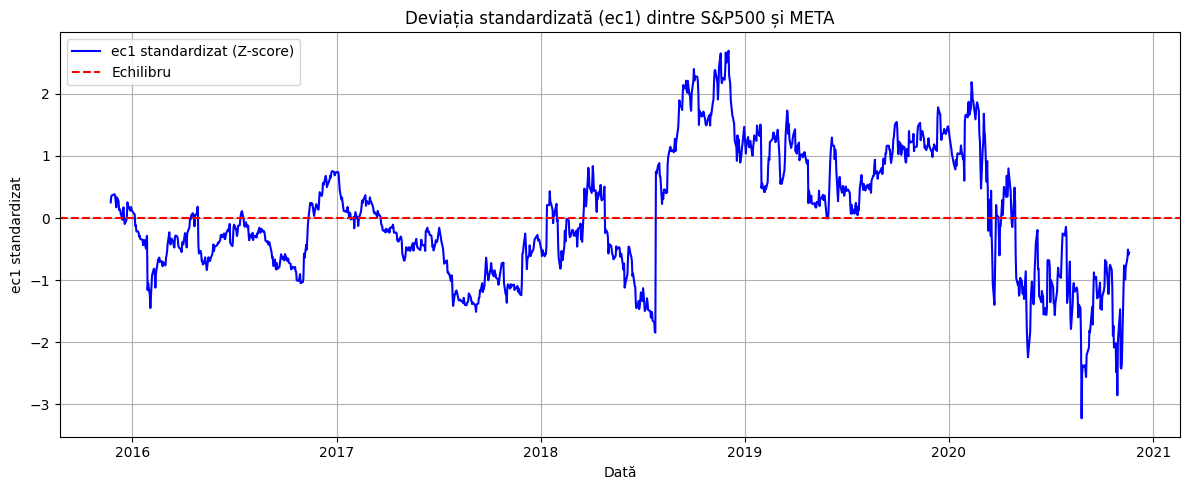

In [ ]:
# Relația estimată direct pe datele originale
ec1 = data['sp500'] - 9.7941 * data['meta']

# Standardizăm ec1 (z-score) pentru vizualizare mai bună
ec1_standardized = (ec1 - ec1.mean()) / ec1.std()

# Plot standardizat
plt.figure(figsize=(12, 5))
plt.plot(data.index, ec1_standardized, label='ec1 standardizat (Z-score)', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Echilibru')
plt.title('Deviația standardizată (ec1) dintre S&P500 și META')
plt.xlabel('Dată')
plt.ylabel('ec1 standardizat')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2422.63
Distribution:                  Normal   AIC:                           4855.26
Method:            Maximum Likelihood   BIC:                           4882.62
                                        No. Observations:                 1759
Date:                Sat, May 03 2025   Df Residuals:                     1758
Time:                        15:20:06   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0441  1.916e-02      2.301  2.141e-02 [6.

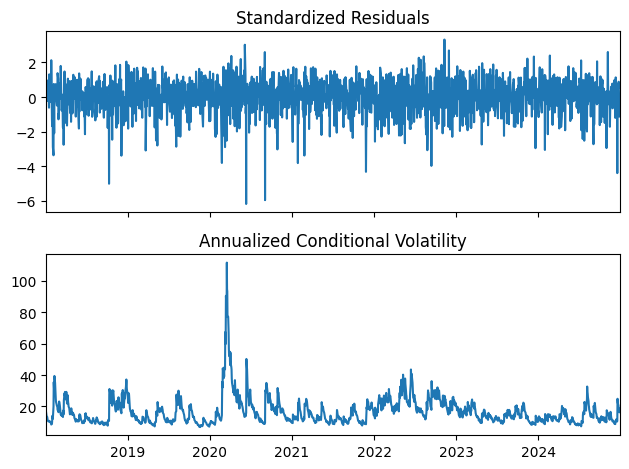

In [ ]:
# Descărcare date S&P500
data = yf.download("^GSPC", start="2018-01-01", end="2024-12-31")
returns = 100 * np.log(data / data.shift(1)).dropna()

# Model EGARCH(1,1)
model = arch_model(returns, vol='EGARCH', p=1, o=1, q=1, dist='normal')
result = model.fit(disp='off')

# Rezumat
print(result.summary())

# Graficul volatilității estimate
result.plot(annualize='D')
plt.tight_layout()
plt.show()

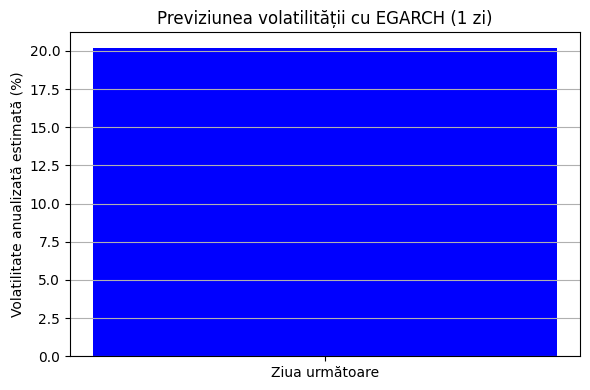

Volatilitatea estimată pentru ziua următoare (anualizată): 20.20%


In [ ]:
# Forecast doar pe 1 zi
forecast = result.forecast(horizon=1)
sigma_next = np.sqrt(forecast.variance.iloc[-1])
vol_next_ann = sigma_next.values[0] * np.sqrt(252)

# Grafic pe o singură zi
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(['Ziua următoare'], [vol_next_ann], color='blue')
plt.ylabel('Volatilitate anualizată estimată (%)')
plt.title('Previziunea volatilității cu EGARCH (1 zi)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

print(f"Volatilitatea estimată pentru ziua următoare (anualizată): {vol_next_ann:.2f}%")